# Chapter 6 - Applied Exercise Solutions

In [57]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
# !pip install l0bnb
from l0bnb import fit_path
from sklearn.feature_selection import SequentialFeatureSelector as SFS # My code
from sklearn.linear_model import LinearRegression as LR # My code
from sklearn.metrics import mean_squared_error
from itertools import combinations # My code

# 8

In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.

**(a)** Create a random number generator and use its `normal()` method to generate a predictor *X* of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.

In [153]:
# rng = np.random.default_rng(0)
rng = np.random
X = rng.default_rng(0).normal(size=100)
epsilon = rng.default_rng(1).normal(size=100)

**(b)** Generate a response vector *Y* of length $n = 100$ according to the model

$$ Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon $$

where $ \beta_0 $, $ \beta_1 $, $ \beta_2 $, and $ \beta_3 $ are constants of your choice.

In [254]:
b0 = 0.5
b1 = -0.8
b2 = 2
b3 = 3.5

Y = b0 + b1*X + b2*(X**2) + b3*(X**3) + epsilon
Y.size


100

**(c)** Use forward stepwise selection in order to select a model containing the predictors $ X, X^2, \ldots , X^{10} $. What is the model obtained according to $ C_p $? Report the coefficients of the model obtained.

In [155]:
Xmat = pd.DataFrame(data=np.empty((100,10)), columns=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'])

for i in range(10):
    # print(i)
    Xmat.iloc[:,i] = X**(i+1)

In [156]:
Xmat['intercept'] = 1

In [157]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

In [158]:
sigma2 = OLS(Y,X).fit().scale

In [92]:
neg_Cp = partial(nCp, sigma2)

In [159]:
# ISLP functions
design = MS(Xmat.columns.drop('intercept')).fit(Xmat)
X_ISLP = design.transform(Xmat)

strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

X_ISLP_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
X_ISLP_Cp.fit(X_ISLP, Y)
X_ISLP_Cp.selected_state_


('x2', 'x3')

In [268]:
# sklearn / neg_mean_squared_error
LR_sk = LR(fit_intercept=True)
SFS_sk = SFS(LR_sk, direction='forward', scoring='neg_mean_squared_error')
SFS_sk.fit(Xmat, Y)
SFS_sk.get_feature_names_out()

array(['x1', 'x2', 'x3', 'x4', 'intercept'], dtype=object)

In [161]:
# sklearn / neg_Cp
LR_sk = LR()
SFS_sk = SFS(LR_sk, direction='forward', scoring=neg_Cp)
SFS_sk.fit(Xmat, Y)
SFS_sk.get_feature_names_out()

array(['x1', 'x2', 'x3', 'x4', 'intercept'], dtype=object)

The ISLP forward selection model returns predictors $X^2$ and $X^3$, while the SciKit Learn forward selection model returns $ X^1 $,  $ X^2 $, $ X^3 $, and $ X^4 $.

In [ ]:
Xreg = Xmat[['intercept', 'x1', 'x2', 'x3', 'x4']]
results = OLS(Y,Xreg).fit()
results.summary()

**(d)** Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?

In [148]:
# ISLP functions
design = MS(Xmat.columns.drop('intercept')).fit(Xmat)
X_ISLP = design.transform(Xmat)

strategy = Stepwise.first_peak(design, direction='backwards', max_terms=len(design.terms))

X_ISLP_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
X_ISLP_Cp.fit(X_ISLP, Y)
X_ISLP_Cp.selected_state_

('x2', 'x3')

In [150]:
# sklearn / neg_Cp
LR_sk = LR()
SFS_sk = SFS(LR_sk, direction='backward', scoring=neg_Cp)
SFS_sk.fit(Xmat, Y)
SFS_sk.get_feature_names_out()

array(['x5', 'x6', 'x7', 'x8', 'x9', 'x10'], dtype=object)

The ISLP backward selection model returns predictors $X^2$ and $X^3$ (same as forward selection), while the SciKit Learn backward selection model returns $ X^5 $,  $ X^6 $, $ X^7 $, $ X^8 $, $ X^9 $ and $ X^10 $.

In [ ]:
Xreg = Xmat[['intercept', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']]
results = OLS(Y,Xreg).fit()
results.summary()

**(e)** Now fit a lasso model to the simulated data, again using $ X, X^2, \ldots , X^{10} $. as predictors. Use cross-validation to select the optimal value of $ \lambda $. Create plots of the cross-validation error as a function of $ \lambda $. Report the resulting coefficient estimates, and discuss the results obtained.

In [209]:
kfold = skm.KFold(5, random_state=0, shuffle=True)
scaler = StandardScaler(with_mean=True,  with_std=True)

lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)

pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(Xmat, Y) # Note both scaler and lassoCV have a .fit() method

# Optimal lambda (alpha)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_, -np.log(tuned_lasso.alpha_)

(0.00851123110504259, 4.766368681167495)

In [195]:
# Standardize manually
Xmat_std = Xmat - Xmat.mean(axis=0)
Xmat_scaled = Xmat.std(axis=0)
Xmat_std = Xmat_std / Xmat_scaled
Xmat_std = Xmat_std.drop('intercept', axis=1) # No intercept


In [228]:
lambdas, soln_array = skl.Lasso.path(Xmat_std, Y, l1_ratio=1, n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=Xmat.columns.drop('intercept')) # , index=-np.log(lambdas)
soln_path['lambdas'] = -np.log(lambdas)

Coefficient values at the optimal lambda are:

In [241]:
soln_path.loc[np.isclose(soln_path['lambdas'], -np.log(tuned_lasso.alpha_), atol=0.05), ]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,lambdas
99,-0.816621,1.969111,9.034783,0.439338,0.0,0.0,0.0,-0.0,0.0,-0.269046,4.771394


In [243]:
np.min(tuned_lasso.mse_path_.mean(axis=1))

0.8505908258613069

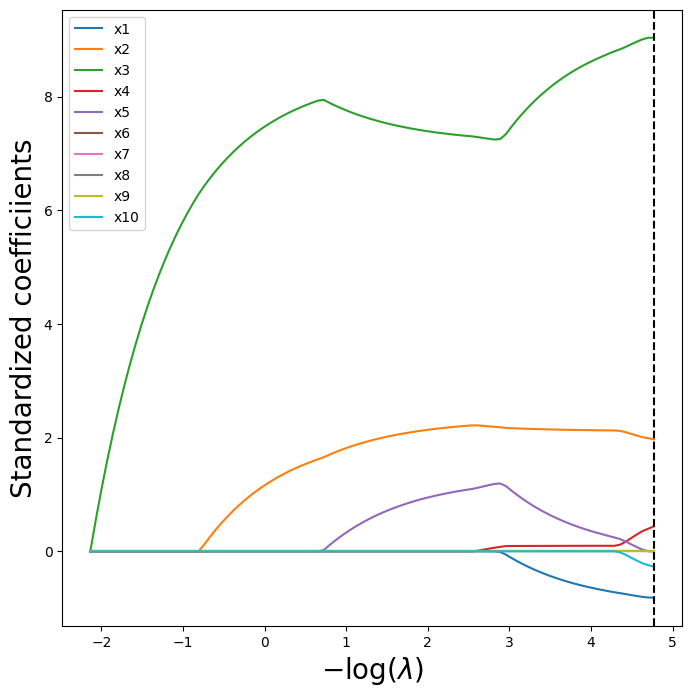

In [250]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, x='lambdas', legend=False)
ax.legend(loc='upper left')
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

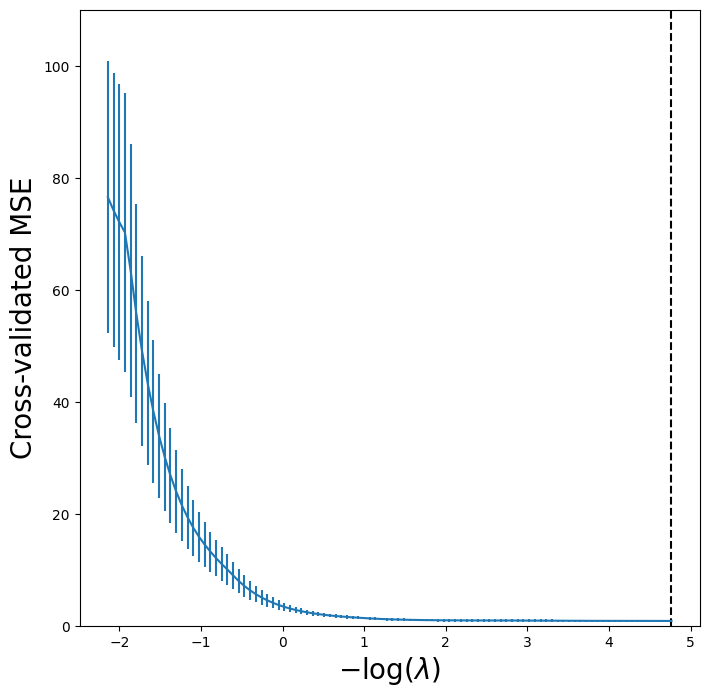

In [249]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(axis=1),
            yerr=tuned_lasso.mse_path_.std(axis=1) / np.sqrt(5))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0,110])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

**(f)** Now generate a response vector *Y* according to the model
$$ Y = \beta_0 + \beta_7 X_7 + \epsilon $$
and perform forward stepwise selection and the lasso. Discuss the results obtained.

In [255]:
b7 = 4.2
Yf = b0 +  b7*(X**7) + epsilon
Yf.size

100

Forward Selection

In [256]:
# Foward selection: ISLP functions
design = MS(Xmat.columns.drop('intercept')).fit(Xmat)
X_ISLP = design.transform(Xmat)

strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

X_ISLP_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
X_ISLP_Cp.fit(X_ISLP, Yf)
X_ISLP_Cp.selected_state_

('x7',)

In [257]:
# Forward selection: sklearn / neg_Cp
LR_sk = LR()
SFS_sk = SFS(LR_sk, direction='forward', scoring=neg_Cp)
SFS_sk.fit(Xmat, Yf)
SFS_sk.get_feature_names_out()

array(['x2', 'x4', 'x7', 'x8', 'intercept'], dtype=object)

In [258]:
# Forward selection: sklearn / neg_mean_squared_error
LR_sk = LR()
SFS_sk = SFS(LR_sk, direction='forward', scoring='neg_mean_squared_error')
SFS_sk.fit(Xmat, Yf)
SFS_sk.get_feature_names_out()

array(['x2', 'x4', 'x7', 'x8', 'intercept'], dtype=object)

Lasso

In [470]:
# Determine optimal lambda via cross-validation
kfold = skm.KFold(5, random_state=0, shuffle=True)
scaler = StandardScaler(with_mean=True,  with_std=True)

lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)

pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(Xmat, Yf) # Note both scaler and lassoCV have a .fit() method

# Optimal lambda (alpha)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_, -np.log(tuned_lasso.alpha_)

(0.20676614824971254, 1.5761668429302627)

In [471]:
# Using scaled X (Xmat_std) created earlier
lambdas, soln_array = skl.Lasso.path(Xmat_std, Yf, l1_ratio=1, n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=Xmat.columns.drop('intercept')) # , index=-np.log(lambdas)
soln_path['lambdas'] = -np.log(lambdas)

Coefficient values at the optimal lambda are:

In [472]:
soln_path.loc[np.isclose(soln_path['lambdas'], -np.log(tuned_lasso.alpha_), atol=0.05), ]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,lambdas
99,0.0,-0.0,0.0,-0.0,0.089406,-0.0,207.46233,-0.0,0.055224,-0.0,1.581192


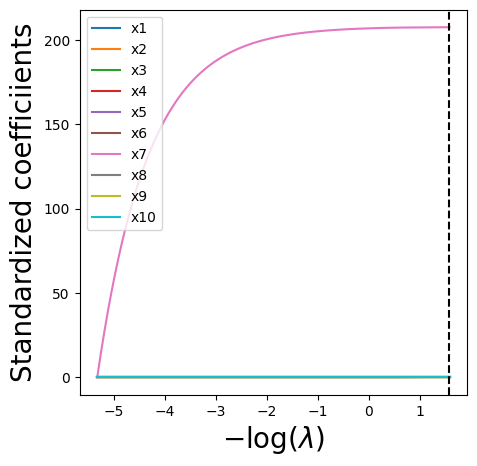

In [473]:
path_fig, ax = subplots(figsize=(5,5))
soln_path.plot(ax=ax, x='lambdas', legend=False)
ax.legend(loc='upper left')
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

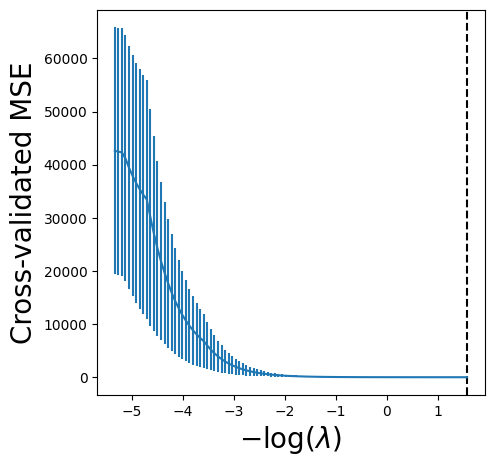

In [474]:
lassoCV_fig, ax = subplots(figsize=(5,5))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(axis=1),
            yerr=tuned_lasso.mse_path_.std(axis=1) / np.sqrt(5))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
# ax.set_ylim([0,110])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

(Dissatisfied with the results of this problem.)

# 9

In this exercise, we will predict the number of applications received using the other variables in the College data set.

In [549]:
College = load_data('College')

In [550]:
College['intercept'] = np.ones(College.shape[0])
College['PrivateB'] = np.where(College['Private'] == 'Yes', 1, 0)

In [341]:
College.head()
# College.dtypes

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,intercept,PrivateB
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1.0,1
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1.0,1
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1.0,1
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1.0,1
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1.0,1


**(a)** Split the data set into a training set and a test set.

In [551]:
College_train, College_test = skm.train_test_split(College, test_size=0.4, random_state=0)

**(b)** Fit a linear model using least squares on the training set, and report the test error obtained.

In [552]:
import statsmodels.api as sm

In [553]:
# Keep these columns for x
x_names = College.columns.drop(['Apps', 'Private'])

In [554]:
# Train model: statsmodels
y_train = College_train['Apps']
x_train = College_train[x_names]
model_sm = sm.OLS(y_train, x_train)
results_sm = model_sm.fit()
# print(results_sm.summary())

In [555]:
# Test model: statsmodels
y_test = College_test['Apps']
x_test = College_test[x_names]
y_pred_sm = results_sm.predict(x_test)
np.mean((y_test - y_pred_sm)**2)


1440756.650335043

In [556]:
# Train model: sklearn
model_skl = LR(fit_intercept=False)
model_skl.fit(y=y_train, X=x_train)
# model_skl.coef_ # yes, same as statsmodels

LinearRegression(fit_intercept=False)

In [733]:
y_pred_skl = model_skl.predict(x_test)
np.mean((y_test - y_pred_skl)**2), model_skl.score(x_test, y_test)

(1440756.6503350264, 0.9082978945824849)

**(c)** Fit a ridge regression model on the training set, with $ \lambda $ chosen by cross-validation. Report the test error obtained.

In [728]:
# alphas must be specified for ElasticNetCV with l1_ratio=0
lambdas = 10**np.linspace(8, -2, 100) / y_train.std()

# Determine optimal lambda via cross-validation
kfold = skm.KFold(5, random_state=0, shuffle=True)
scaler = StandardScaler(with_mean=True,  with_std=True)

# ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold) # Returns alpha = 0.013815756218158292 (convergence warning)
# ridgeCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=0.01, cv=kfold) # Similar to RidgeCV()
ridgeCV = skl.RidgeCV(alphas=lambdas, cv=kfold) # Returns alpha = 3.0249695170752435 (no warning)

pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(x_train, y_train)

# Optimal lambda (alpha)
tuned_ridge = pipeCV.named_steps['ridge']
tuned_ridge.alpha_, -np.log(tuned_ridge.alpha_)

(3.0249695170752435, -1.106901014432112)

In [559]:
# Standardize manually
x_train_centered = x_train - x_train.mean(axis=0)
x_train_scaled = x_train.std(axis=0)
x_train_std = x_train_centered / x_train_scaled
x_train_std = x_train_std.drop('intercept', axis=1) # Drop intercept

In [560]:
# Standardize with StandardScaler
x_train_std2 = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns, index=x_train.index) # Slightly different
x_train_std2 = x_train_std2.drop('intercept', axis=1)

In [561]:
x_test_std = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns, index=x_test.index)
x_test_std = x_test_std.drop('intercept', axis=1)

In [562]:
# lambdas, soln_array = skl.Ridge.path(x_train_std, y_train, alphas=lambdas)[:2]
lambdas, soln_array = skl.ElasticNet.path(x_train_std, y_train, l1_ratio=0, alphas=lambdas)[:2]
# lambdas, soln_array = skl.ElasticNet.path(x_train_std, y_train, l1_ratio=0.01, n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=x_train_std.columns)
soln_path['lambdas'] = -np.log(lambdas)

# Identify coefficients corresponding to optimal lambda
soln_path.loc[np.isclose(soln_path['lambdas'], -np.log(tuned_ridge.alpha_), atol=0.05), ]

/Users/andy/anaconda3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/andy/anaconda3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5641857939.789972, tolerance: 1128463.36
  model = cd_fast.enet_coordinate_descent_gram(
/Users/andy/anaconda3/envs/islp/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/andy/anaconda3/envs/islp/lib/python3.11/site-packages/sklear

,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,PrivateB,lambdas
39,560.108662,490.830489,183.054467,156.870345,463.07808,173.500803,41.210112,112.522001,54.938822,57.612203,143.298104,130.568401,37.869695,-67.418967,148.585085,86.109242,-221.906486,-1.106901


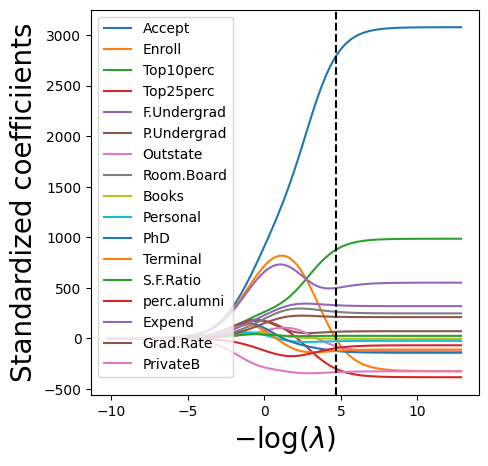

In [567]:
path_fig, ax = subplots(figsize=(5,5))
soln_path.plot(ax=ax, x='lambdas', legend=False)
ax.legend(loc='upper left')
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

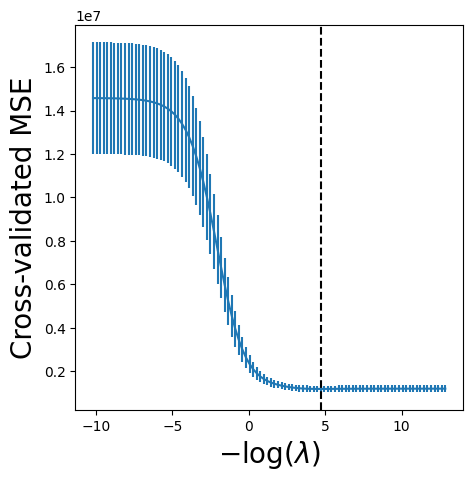

In [566]:
ridgeCV_fig, ax = subplots(figsize=(5,5))
ax.errorbar(-np.log(tuned_ridge.alphas_),
            tuned_ridge.mse_path_.mean(axis=1),
            yerr=tuned_ridge.mse_path_.std(axis=1) / np.sqrt(5))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [731]:
# Fit the final ridge model / This is possibly incorrect as it did not converge
# ridge = skl.ElasticNet(l1_ratio=0, alpha=tuned_ridge.alpha_)
ridge = skl.Ridge(alpha=tuned_ridge.alpha_)
ridge.fit(x_train_std, y_train)
np.linalg.norm(ridge.coef_)
ridge.coef_

array([2869.45014182,  -85.05458236,  905.8582606 , -323.84080303,
        506.30478223,   66.34484928,  -91.19945842,  258.37119498,
         -4.50870942,  -28.06119439, -129.73440554, -120.88182314,
         24.44825701,  -89.67966858,  324.95873374,  211.82336667,
       -333.15242931])

In [732]:
# MSE
y_pred_ridge = ridge.predict(x_test_std)
np.mean((y_test - y_pred_ridge)**2), ridge.score(x_test_std, y_test)

(1574849.7403416282, 0.8997630607001035)

In [570]:
# Fit the final ridge model (v2)
ridge2 = skl.Ridge(alpha= tuned_ridge.alpha_) # 9.30373838238355
ridge2.fit(x_train_std, y_train)
np.linalg.norm(ridge2.coef_)
ridge2.coef_

array([3077.92515822, -324.39168796,  985.29628335, -384.85122231,
        550.61114847,   70.27945433, -128.98387623,  246.70830033,
         -5.79566649,  -24.91411927, -142.6413554 , -110.8264016 ,
         24.15830143,  -69.18644628,  318.1895823 ,  209.76185057,
       -326.50589917])

In [571]:
# MSE
y_pred_ridge2 = ridge2.predict(x_test_std)
np.mean((y_test - y_pred_ridge2)**2), ridge2.score(x_test_std, y_test)

(1463680.5102607505, 0.9068388236012777)

**(d)** Fit a lasso model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [572]:
# alphas must be specified for ElasticNetCV with l1_ratio=0
lambdas = 10**np.linspace(8, -2, 100) / y_train.std()

# Determine optimal lambda via cross-validation
kfold = skm.KFold(5, random_state=0, shuffle=True)
scaler = StandardScaler(with_mean=True,  with_std=True)
lassoCV = skl.LassoCV(alphas=lambdas, cv=kfold)
# lassoCV = skl.LassoCV(n_alphas=100, cv=kfold) # Or this

pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(x_train, y_train)

# Optimal lambda (alpha)
tuned_ridge = pipeCV.named_steps['lasso']
tuned_ridge.alpha_, -np.log(tuned_lasso.alpha_)

(12.211854147161228, 1.5761668429302627)

In [573]:
lambdas, soln_array = skl.ElasticNet.path(x_train_std, y_train, l1_ratio=1, alphas=lambdas)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=x_train_std.columns)
soln_path['lambdas'] = -np.log(lambdas)

# Identify coefficients corresponding to optimal lambda
soln_path.loc[np.isclose(soln_path['lambdas'], -np.log(tuned_ridge.alpha_), atol=0.05), ]

,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,PrivateB,lambdas
33,2947.61102,-0.0,823.133757,-242.832025,351.260744,53.423567,-61.985103,224.046998,-0.0,-3.839441,-105.882139,-111.431308,0.0,-66.606661,284.603568,166.198213,-319.031348,-2.502407


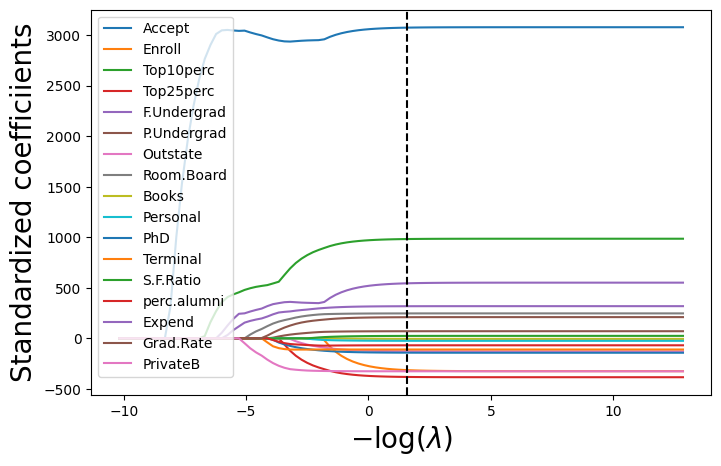

In [574]:
path_fig, ax = subplots(figsize=(8,5))
soln_path.plot(ax=ax, x='lambdas', legend=False)
ax.legend(loc='upper left')
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

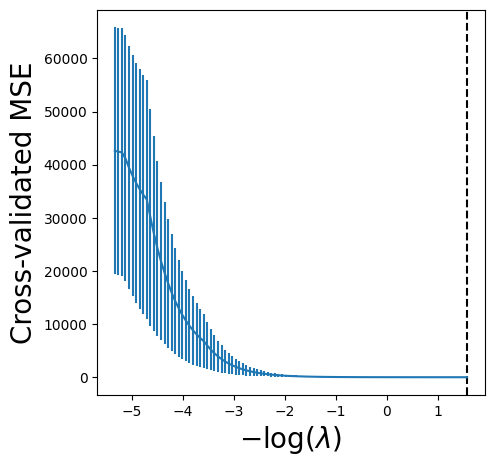

In [575]:
ridgeCV_fig, ax = subplots(figsize=(5,5))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(axis=1),
            yerr=tuned_lasso.mse_path_.std(axis=1) / np.sqrt(5))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [576]:
# Fit the final ridge model
lasso = skl.ElasticNet(l1_ratio=1, alpha=tuned_lasso.alpha_)
lasso.fit(x_train_std, y_train)
np.linalg.norm(lasso.coef_)
lasso.coef_

array([3074.48240241, -314.79266338,  982.42795336, -382.35641997,
        544.32040371,   70.07068877, -127.80938448,  246.40349034,
         -5.52985494,  -24.62618568, -142.00170923, -110.79061395,
         23.74466339,  -69.24464201,  317.55580911,  208.93436363,
       -326.38226889])

In [577]:
# MSE
y_pred_lasso = lasso.predict(x_test_std)
np.mean((y_test - y_pred_lasso)**2), lasso.score(x_test_std, y_test)

(1464602.6879043016, 0.9067801283098397)

In [578]:
# Fit the final ridge model (v2) / Same as ElasticNet above
lasso2 = skl.Lasso(alpha= tuned_lasso.alpha_)
lasso2.fit(x_train_std, y_train)
np.linalg.norm(lasso2.coef_)
lasso2.coef_

array([3074.48240241, -314.79266338,  982.42795336, -382.35641997,
        544.32040371,   70.07068877, -127.80938448,  246.40349034,
         -5.52985494,  -24.62618568, -142.00170923, -110.79061395,
         23.74466339,  -69.24464201,  317.55580911,  208.93436363,
       -326.38226889])

In [579]:
# MSE
y_pred_lasso2 = lasso2.predict(x_test_std)
np.mean((y_test - y_pred_lasso2)**2), lasso2.score(x_test_std, y_test)

(1464602.6879043016, 0.9067801283098397)

All coefficients are non-zero; there is no shrinkage.

**(e)** Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

In [649]:
pca = PCA(n_components=17)
linreg = skl.LinearRegression()
# scaler: defined earlier
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(x_train, y_train)
pipe.named_steps['linreg'].coef_

array([  384.34096237,  1540.99540265,  -140.4024958 ,   657.35183154,
        1086.90468239,  -374.11833727,  -410.83627119,   152.19807265,
        -215.15458676,   145.4991761 ,   253.17285117,   105.92699924,
        -173.3232292 ,  -413.12300006,   232.71142197, -2153.70117474,
        1353.43179879])

In [645]:
# Now vary n_components with GridSearchCV()
param_grid = {'pca__n_components': range(1, 18)} # There are only 18 variables in x_train
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=17)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 18)},
             scoring='neg_mean_squared_error')

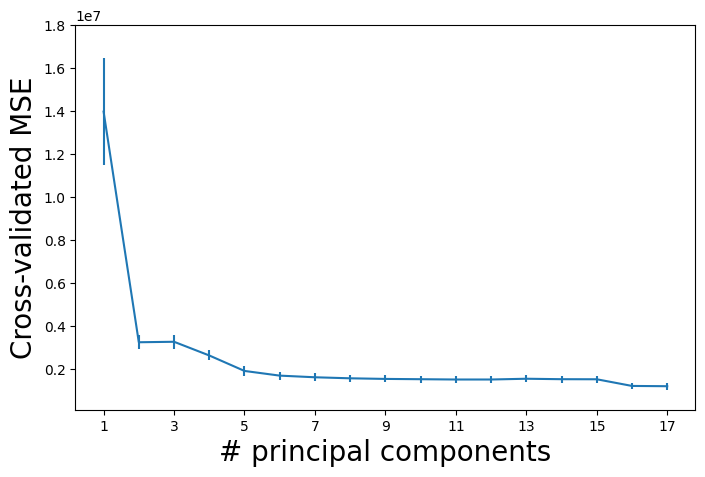

In [646]:
pcr_fig, ax = subplots(figsize=(8,5))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([1e5,18e6]);

In [605]:
# MSE is minimized with all 18 components present (bo-ring)
-grid.cv_results_['mean_test_score']

array([13960529.91343775,  3236864.70251011,  3259253.30708963,
        2622403.71063626,  1903036.04367871,  1685337.90575076,
        1608711.67673595,  1560707.62047419,  1532088.4514508 ,
        1518684.98002164,  1504633.71497656,  1504903.33240465,
        1540333.72409139,  1519111.68902992,  1515710.18215588,
        1205861.4587141 ,  1192831.79554447,  1192831.79554447])

In [636]:
# Proportion of variance explained by each component (in descending order)
pipe.named_steps['pca'].explained_variance_ratio_

array([0.31927034, 0.25884075, 0.07308499, 0.05587764, 0.05320715,
       0.04968531, 0.03546127, 0.03424866, 0.02913302, 0.02604923,
       0.01991793, 0.0174524 , 0.01087088, 0.00638955, 0.00536516,
       0.00359547, 0.00155027])

In [ ]:
# Test MSE / Wrong?
y_pred_pca = pipe.named_steps['linreg'].predict(x_test_std)
np.mean((y_test - y_pred_pca)**2), pipe.named_steps['linreg'].score(x_test_std, y_test)

# Ouch, performs horribly -- this might be wrong, because I'm feeding in x instead of principal components

In [691]:
# Same procedure, step-by-step
pca2 = PCA(n_components=17)
linreg2 = skl.LinearRegression()

# Obtain principal components
pca2.fit(x_train_std)
x_train_std_pca = pca2.transform(x_train_std)

# Fit a linear model with principal components
linreg2.fit(x_train_std_pca, y_train)
linreg2.coef_

# Obtain principal components - for test x
x_test_std_pca = pca2.transform(x_test_std)

# Get predictions with linear model
y_pred_pca2 = linreg2.predict(x_test_std_pca)

# Test MSE
np.mean((y_test - y_pred_pca2)**2), linreg2.score(x_test_std_pca, y_test)


(1463337.2224509746, 0.9068606733806372)

The test MSE is minimized when all $ M = 17 $ components are used.

**(f)** Fit a PLS model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.

In [721]:
pls = PLSRegression(n_components=9, scale=True)
param_grid = {'n_components':range(1, 17)}
grid = skm.GridSearchCV(pls, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(n_components=9),
             param_grid={'n_components': range(1, 17)},
             scoring='neg_mean_squared_error')

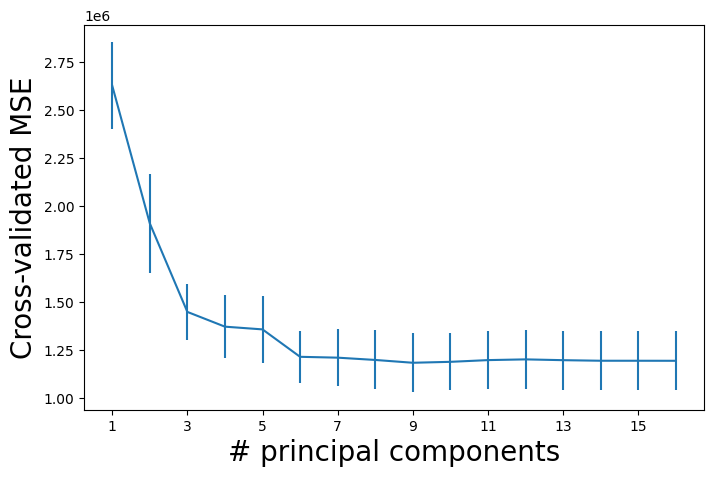

In [699]:
pls_fig, ax = subplots(figsize=(8,5))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2]);


In [720]:
(-grid.cv_results_['mean_test_score']).argmin()

8

In [726]:
pls.fit(x_train, y_train)
y_pred_pls = pls.predict(x_test)
np.mean((y_test - y_pred_pls)**2), pls.score(x_test, y_test)


(1441426.8097287316, 0.9082552398931216)

The CV MSE is minimized at index 8, i.e. with 9 components.

**(g)** Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

The linear model and PLS model have the highest scores, at 0.908.

# 10

We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.

**(a)** Generate a data set with p = 20 features, n = 1,000 observations, and an associated quantitative response vector generated according to the model

$$ Y = X \beta + \epsilon $$

where $ \beta $ has some elements that are exactly equal to zero.

In [327]:
rng = np.random
dataNorm = rng.default_rng(111).normal(size=(1000, 20)) # Half the data is normal
# dataRand = rng.default_rng(110).random(size=(1000, 10)) # Half the data is uniform
X = np.concatenate([dataNorm], axis=1)
X = pd.DataFrame(X)
X.columns = [f'x{i+1:02d}' for i in range(X.shape[1])]

In [375]:
Beta = rng.default_rng(112).integers(-100, 100, size=(15,1))
Beta = np.concatenate([Beta, np.zeros((5,1))]) # Last 5 coefficients are 0
epsilon = rng.default_rng(113).normal(size=1000)
Y = X.dot(Beta) + epsilon[:, None]

In [329]:
df = X.copy()
df['y'] = Y

**(b)** Split your dataset into a training set containing 100 observations and a test set containing 900 observations.

In [330]:
df_train, df_test = skm.train_test_split(df, test_size=900, random_state=0)
X_train, X_test = skm.train_test_split(X, test_size=900, random_state=0)
Y_train, Y_test = skm.train_test_split(Y, test_size=900, random_state=0)

**(c)** Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

In [351]:

estimator = skl.LinearRegression(fit_intercept=True)
cv = 5
n_features = X.shape[1]
# n_features = 8 # For testing
# estimator.fit(X_train, Y_train)

In [352]:
# Master list of all possible subsets

from itertools import combinations

subsetList = [] # List with k elements, each element k is the set of all possible combinations for length-k features

for k in range(n_features):
    subsetListK = combinations(range(n_features), k + 1)
    subsetList.append(list(subsetListK)) # Note the conversion to list

# selectCols = list(list(subsetList[3])[2])
# X_train.iloc[:, selectCols]


In [353]:
# Note: 25m 42.5s runtime

bestParams = np.empty(shape=(n_features, 5)) # k, bestScore, bestMSE, mseMean, mseSE
bestSubsetList = [] # bestSubset

for k, subsetListK in enumerate(subsetList): # For each list of subsets of the same size k, loop of all k
    bestScore = -np.inf
    bestSubset = None
    bestMSE = None
    mseListK = np.empty(len(subsetListK))
    for i, subset in enumerate(subsetListK):
        # print(subset)
        # test = X_train.iloc[:, list(subset)]
        estimator.fit(X_train.iloc[:, list(subset)], Y_train)
        score = estimator.score(X_train.iloc[:, list(subset)], Y_train)
        Y_pred = estimator.predict(X_train.iloc[:, list(subset)])
        mse = ((Y_train - Y_pred)**2).mean(axis=0).item() # .item() elimintes series wrapper
        mseListK[i] = mse # All MSEs for every combination of fixed k, to calculate mean and SE of MSE
        if score > bestScore: # Choose best subset for a particular k
            bestScore, bestSubset, bestMSE = score, subset, mse

    # Once have iterated through all combinations for a specific K, save values
    # print(mseListK)
    mseMean = mseListK.mean(axis=0)
    mseSE = mseListK.std(axis=0) / np.sqrt(mseListK.shape[0])
    # print(mseListK)
    # print(f'Best {bestMSE}, Mean {mseMean}, SE {mseSE}')

    bestSubsetList.append(bestSubset)
    bestParams[k, :] = k, bestScore, bestMSE, mseMean, mseSE


In [201]:
# Sample code
def best_subset(estimator, X, y, max_size=8, cv=5):
    '''Calculates the best model of up to max_size features of X.
   estimator must have a fit and score functions.
   X must be a DataFrame.'''

    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) 
               for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = -np.inf
        best_subset = None
        for subset in subsets_k: # for each subset
            estimator.fit(X.iloc[:, list(subset)], y)
            # get the subset with the best score among subsets of the same size
            score = estimator.score(X.iloc[:, list(subset)], y)
            if score > best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)

    # compare best subsets of each size
    best_score = -np.inf
    best_subset = None
    list_scores = []
    for subset in best_size_subset:
        score = cross_val_score(estimator, X.iloc[:, list(subset)], y, cv=cv).mean()
        list_scores.append(score)
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score, best_size_subset, list_scores

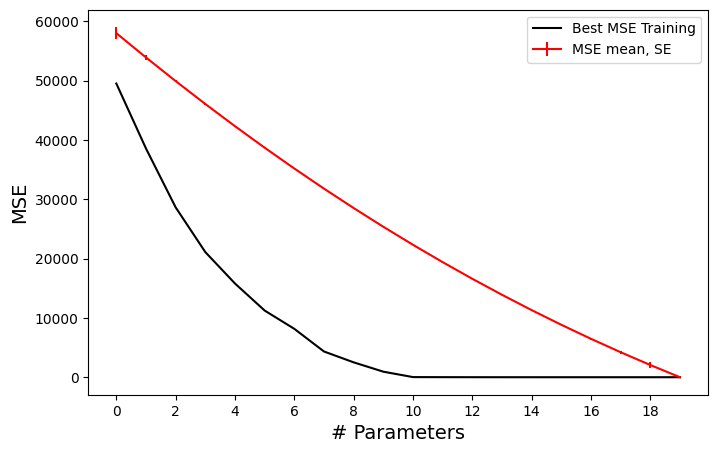

In [360]:
# bestSubsetList
# bestParams

fig, ax = subplots(figsize=(8,5))
ax.plot(bestParams[:, 0], bestParams[:, 2], 'k', label='Best MSE Training')
ax.errorbar(bestParams[:, 0], bestParams[:, 3], bestParams[:, 4], label='MSE mean, SE', c='r')
ax.set_ylabel('MSE', fontsize=14)
ax.set_xlabel('# Parameters', fontsize=14)
ax.set_xticks(np.arange(bestParams.shape[0])[::2])
ax.legend();

In [365]:
bestParams[:, 2].argmin()

19

**(d)** Plot the test set MSE associated with the best model of each size.

In [361]:
mseTestList = np.empty(len(bestSubsetList))

for k, subset in enumerate(bestSubsetList): # Loop over best models for each size k
    estimator.fit(X_train.iloc[:, list(subset)], Y_train)
    Y_pred_test = estimator.predict(X_test.iloc[:, list(subset)])
    mse_test = ((Y_test - Y_pred_test)**2).mean(axis=0).item()
    mseTestList[k] = mse_test

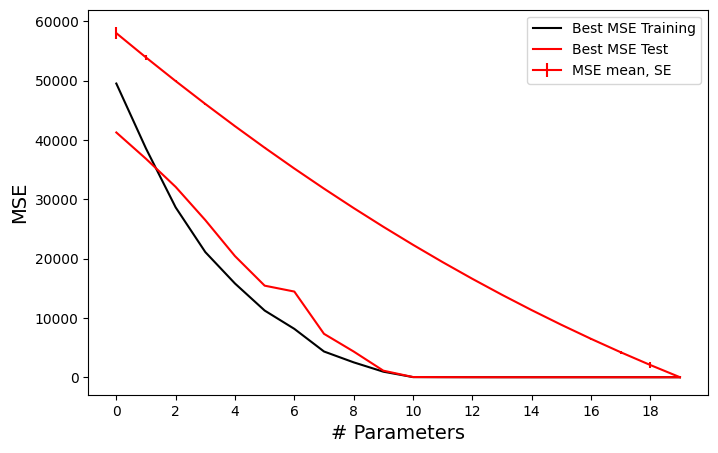

In [362]:
ax.plot(bestParams[:, 0], mseTestList, c='r', label="Best MSE Test")
ax.legend()
# ax.set_ylim([0,20])
fig

**(e)** For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.

In [369]:
# The test MSE is minimized for a model with 15 of the parameters
mseTestList.argmin()

14

**(f)** How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.

In [370]:
# The test MSE is minimized exactly for the true model (beta 15-19 are zero)
bestSubsetList[14]

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)

In [404]:
estimator.fit(X_test.iloc[:, list(bestSubsetList[14])], Y_test)
Beta_test = estimator.coef_

In [392]:
# Differences between test coefficients and true coefficients is minimal!
(Beta_test.reshape((15,1)) - Beta[0:15]).T

array([[ 0.00344874,  0.00170051, -0.01165855, -0.02347262, -0.01673252,
         0.02716982,  0.04389819,  0.00204445,  0.03759637, -0.0182783 ,
         0.02343987,  0.05810857, -0.01393239, -0.04136848, -0.00288585]])

In [393]:
# Most percentage differences are less than 1%
( (Beta_test.reshape((15,1)) - Beta[0:15]) / Beta[0:15] ).T

array([[-5.56247987e-05, -2.20845935e-05, -2.11973556e-04,
        -3.45185652e-04, -5.39758627e-04,  4.60505414e-04,
         8.44195957e-04, -2.10767597e-05, -1.87981853e-02,
         2.15038831e-04, -2.89381161e-04, -5.81085672e-02,
        -4.64412856e-03, -6.36438163e-04, -7.21461929e-04]])

**(g)** Create a plot displaying

$$ \sqrt{ \sum_{p=1}^j \Bigl( \beta_j - \hat{\beta}_j^r \Bigr)^2 } $$

for a range of values of *r*, where $ \hat{\beta}^r_j $ is the *j*th coefficient estimate for the best model containing *r* coefficients. Comment on what you observe. How does this compare to the test MSE plot from (d)?


In [435]:
mseBeta = np.empty(shape=(len(bestSubsetList),2))

for r in range(len(bestSubsetList)):
    Beta_true = Beta[list(bestSubsetList[r])]
    # Beta_true

    estimator.fit(X_test.iloc[:, list(bestSubsetList[r])], Y_test)
    Beta_r = estimator.coef_.reshape((len(bestSubsetList[r]), 1))
    # Beta_r

    mseBeta[r, 1] = np.sqrt( ((Beta_true - Beta_r)**2).sum(axis=0) )

    mseBeta[r, 0] = r


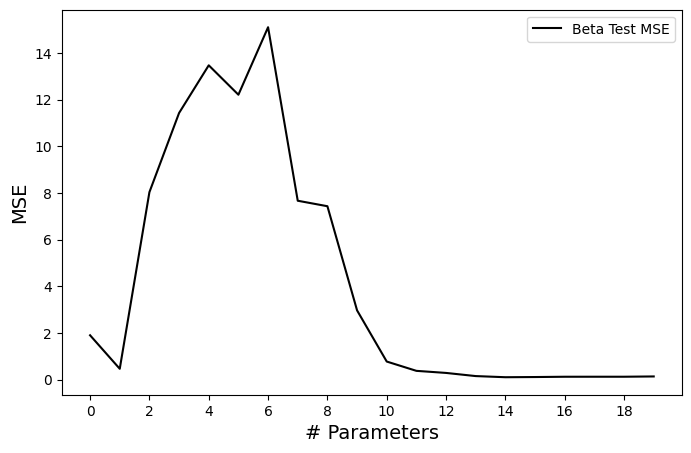

In [437]:
fig, ax = subplots(figsize=(8,5))
ax.plot(mseBeta[:, 0], mseBeta[:, 1], 'k', label='Beta Test MSE')
ax.set_ylabel('MSE', fontsize=14)
ax.set_xlabel('# Parameters', fontsize=14)
ax.set_xticks(np.arange(mseBeta.shape[0])[::2])
ax.legend();

In [440]:
mseBeta[:,1].argmin()

14

The minimum "mse" occurs for the same number of parameters -- 15. Again, this turns out to correspond to the true model, meaning that best parameter selection succeeded in identifiying the true model.

# *11

We will now try to predict per capita crime rate in the Boston data set.

### **(a)** Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression, and PCR. Present and discuss results for the approaches that you consider.

In [3]:
Boston = load_data("Boston")

In [9]:
Boston.dtypes
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [10]:
BostonY = Boston['crim']
BostonX = Boston.drop(columns='crim')

In [14]:
BostonY_train, BostonY_test = skm.train_test_split(BostonY, test_size=450, random_state=0)
BostonX_train, BostonX_test = skm.train_test_split(BostonX, test_size=450, random_state=0)

In [48]:
scaler = StandardScaler().fit(BostonX_train)
BostonX_train_scaled = scaler.transform(BostonX_train)
BostonX_test_scaled = scaler.transform(BostonX_test)

### Best Subset Selection

In [18]:
estimator = skl.LinearRegression(fit_intercept=True)
n_features = BostonX.shape[1]

subsetList = [] # List with k elements, each element k is the set of all possible combinations for length-k features

for k in range(n_features):
    subsetListK = combinations(range(n_features), k + 1)
    subsetList.append(list(subsetListK)) # Note the conversion to list

In [19]:
# Training MSE

bestParams = np.empty(shape=(n_features, 5)) # k, bestScore, bestMSE, mseMean, mseSE
bestSubsetList = [] # bestSubset

for k, subsetListK in enumerate(subsetList): # For each list of subsets of the same size k, loop of all k
    bestScore = -np.inf
    bestSubset = None
    bestMSE = None
    mseListK = np.empty(len(subsetListK))
    for i, subset in enumerate(subsetListK):
        # print(subset)
        estimator.fit(BostonX_train.iloc[:, list(subset)], BostonY_train)
        score = estimator.score(BostonX_train.iloc[:, list(subset)], BostonY_train)
        BostonY_pred = estimator.predict(BostonX_train.iloc[:, list(subset)])
        mse = ((BostonY_train - BostonY_pred)**2).mean(axis=0).item() # .item() elimintes series wrapper
        mseListK[i] = mse # All MSEs for every combination of fixed k, to calculate mean and SE of MSE
        if score > bestScore: # Choose best subset for a particular k
            bestScore, bestSubset, bestMSE = score, subset, mse

    # Once have iterated through all combinations for a specific K, save values
    mseMean = mseListK.mean(axis=0)
    mseSE = mseListK.std(axis=0) / np.sqrt(mseListK.shape[0])
    
    bestSubsetList.append(bestSubset)
    bestParams[k, :] = k, bestScore, bestMSE, mseMean, mseSE

In [22]:
bestParams[:, 2].argmin()

11

In [23]:
# Test MSE

mseTestList = np.empty(len(bestSubsetList))

for k, subset in enumerate(bestSubsetList): # Loop over best models for each size k
    estimator.fit(BostonX_train.iloc[:, list(subset)], BostonY_train)
    BostonY_pred_test = estimator.predict(BostonX_test.iloc[:, list(subset)])
    mse_test = ((BostonY_test - BostonY_pred_test)**2).mean(axis=0).item()
    mseTestList[k] = mse_test

In [169]:
min(mseTestList), mseTestList.argmin()

(44.63033400575772, 1)

In [40]:
print(BostonX.columns[list(bestSubsetList[1])].values)

['rad' 'lstat']


The best subset, with lowest test MSE, has two parameters: `rad` and `lstat`.

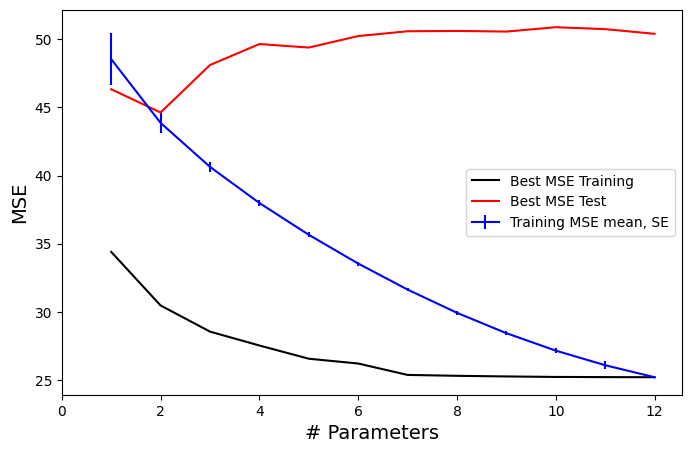

In [47]:
fig, ax = subplots(figsize=(8,5))
ax.plot(bestParams[:, 0] + 1, bestParams[:, 2], 'k', label='Best MSE Training')
ax.errorbar(bestParams[:, 0] + 1, bestParams[:, 3], bestParams[:, 4], label='Training MSE mean, SE', c='b')
ax.plot(bestParams[:, 0] + 1, mseTestList, c='r', label="Best MSE Test")
ax.set_ylabel('MSE', fontsize=14)
ax.set_xlabel('# Parameters', fontsize=14)
ax.set_xticks(np.arange(bestParams.shape[0]+1)[::2])
ax.legend();

### Lasso

In [171]:
n_alphas = 200
alphas = np.logspace(1, -3, n_alphas)

coefs = []
scores = []
for alpha in alphas:
    lasso = skl.Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(BostonX_train_scaled, BostonY_train)
    coefs.append(lasso.coef_)
    scores.append(mean_squared_error(BostonY_test, lasso.predict(BostonX_test_scaled)))

In [172]:
# What is the lowest MSE, and to which alpha does it correspond?
min(scores), scores.index(min(scores)), alphas[67]

(44.95731895253752, 67, 0.4500557675700497)

In [112]:
# What are the coefficients that correspond to that alpha?
coefs[67] # Nonzero coefficents 0, 5, 7, 10

array([ 0.17655488, -0.        , -0.        ,  0.        , -0.        ,
       -0.09104829, -0.        ,  3.57160313, -0.        , -0.        ,
        2.05470986, -0.        ])

In [117]:
# Many coefficients are zeroed-out. The non-zero coefficients are:
print(BostonX_train.columns[list([0, 5, 7, 10])].values)

['zn' 'age' 'rad' 'lstat']


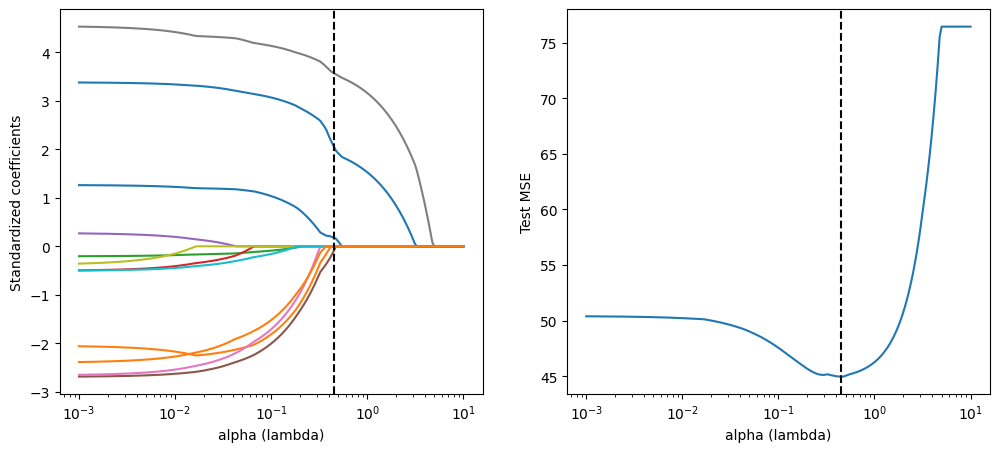

In [110]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(12,5))
ax1.plot(alphas, coefs)
ax1.axvline(alphas[67], c='k', ls='--')
ax1.set_xscale('log')
ax1.set_xlabel('alpha (lambda)')
ax1.set_ylabel('Standardized coefficients');

ax2.plot(alphas, scores)
ax2.axvline(alphas[67], c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel('alpha (lambda)')
ax2.set_ylabel('Test MSE');

### Ridge

In [173]:
n_alphas = 200
alphas = np.logspace(4, -1, n_alphas)

coefs = []
scores = []
for alpha in alphas:
    ridge = skl.Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(BostonX_train_scaled, BostonY_train)
    coefs.append(ridge.coef_)
    scores.append(mean_squared_error(BostonY_test, ridge.predict(BostonX_test_scaled)))

In [174]:
# What is the lowest MSE, and to which alpha does it correspond?
min(scores), scores.index(min(scores)), alphas[113]

(45.531671032266765, 113, 14.481182276745331)

In [199]:
# What are the coefficients that correspond to that alpha?
print(f'{coefs[113]}')

[ 0.79208153 -0.95186491 -0.08851428  0.39028996 -0.03857702 -0.87079331
 -0.84847987  2.81736179  0.57970914 -0.02875175  1.84662252 -1.15899624]


In [167]:
print(BostonX_train.columns.values)

['zn' 'indus' 'chas' 'nox' 'rm' 'age' 'dis' 'rad' 'tax' 'ptratio' 'lstat'
 'medv']


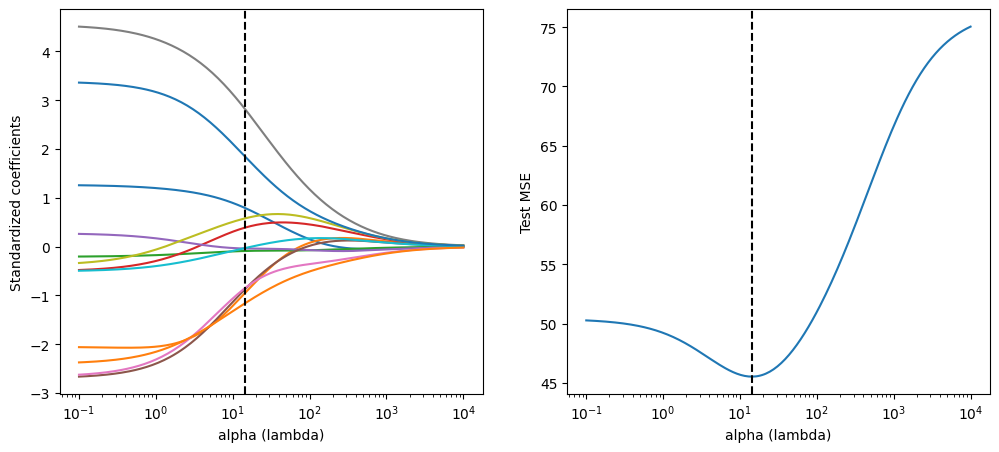

In [168]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(12,5))
ax1.plot(alphas, coefs)
ax1.axvline(alphas[113], c='k', ls='--')
ax1.set_xscale('log')
ax1.set_xlabel('alpha (lambda)')
ax1.set_ylabel('Standardized coefficients');

ax2.plot(alphas, scores)
ax2.axvline(alphas[113], c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel('alpha (lambda)')
ax2.set_ylabel('Test MSE');

### PCR

In [175]:
pca = PCA()
BostonX_train_pca = pca.fit_transform(BostonX_train_scaled)
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 55.39,  67.79,  76.13,  83.67,  88.94,  92.27,  95.1 ,  96.85,
        98.08,  99.07,  99.75, 100.01])

In [180]:
components = range(0, BostonX_train_scaled.shape[1]+1)
scores = []
linear = skl.LinearRegression()

# Intercept only
score = -skm.cross_val_score(linear, np.ones((len(BostonY_train), 1)), BostonY_train, cv=10, scoring='neg_mean_squared_error').mean()    
scores.append((score.mean(), score.std()))

for comp in components:
    score = -skm.cross_val_score(linear, BostonX_train_pca[:, 0:comp+1], BostonY_train, cv=10, scoring='neg_mean_squared_error')
    scores.append((score.mean(), score.std()))
scores = np.array(scores)

In [184]:
# CV finds minimum MSE at 9 components
scores[:,0].argmin()

9

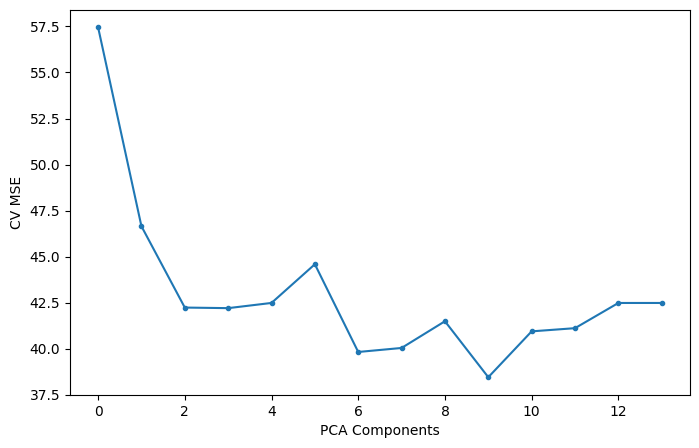

In [182]:
fig, ax = subplots(figsize=(8,5))
ax.plot(range(0, BostonX_train_scaled.shape[1]+2), scores[:,0], '.-')
ax.set_xlabel('PCA Components')
ax.set_ylabel('CV MSE');

In [186]:
BostonX_test_pca = pca.transform(BostonX_test_scaled)

# Optimum number of components: 9
opt_comp = scores[:,0].argmin()
linear = skl.LinearRegression()

# Fit only the optimum number of components
linear.fit(BostonX_train_pca[:, :opt_comp], BostonY_train)

# Get test sample error
BostonY_pred = linear.predict(BostonX_test_pca[:,:opt_comp])
mean_squared_error(BostonY_test, BostonY_pred)

51.395898359146415

In [188]:
# Produces same results (redundant)
pca2 = PCA(n_components=9)
linear2 = skl.LinearRegression()

# Obtain training principal components
pca2.fit(BostonX_train_scaled)
BostonX_train_scaled_pca2 = pca2.transform(BostonX_train_scaled)

# Fit a linear model with training principal components
linear2.fit(BostonX_train_scaled_pca2, BostonY_train)
linear2.coef_

# Obtain testing principal components
BostonX_test_scaled_pca2 = pca2.transform(BostonX_test_scaled)

# Get predictions with linear model
BostonY_pred_pca2 = linear2.predict(BostonX_test_scaled_pca2)

# Test MSE
mean_squared_error(BostonY_test, BostonY_pred_pca2)

51.39589835914644

### PLS

In [190]:
components = range(1, BostonX_train_scaled.shape[1]+1)
scores = []

for comp in components:
    pls = PLSRegression(n_components=comp)
    score = -skm.cross_val_score(pls, BostonX_train_scaled, BostonY_train, cv=10, scoring='neg_mean_squared_error')
    scores.append((score.mean(), score.std()))
scores = np.array(scores)

In [194]:
# CV finds minimum MSE at 2 components
scores[:,0].argmin()

2

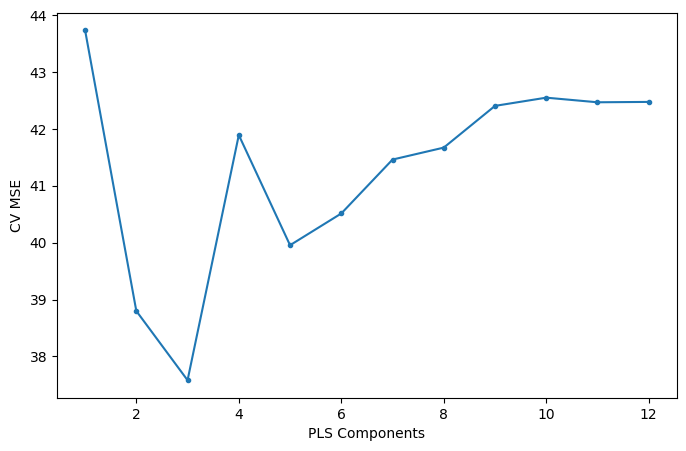

In [200]:
fig, ax = subplots(figsize=(8,5))
ax.plot(range(1, BostonX_train_scaled.shape[1] + 1), scores[:,0], '.-')
ax.set_xlabel('PLS Components')
ax.set_ylabel('CV MSE');

In [197]:
pls = PLSRegression(n_components=scores[:,0].argmin())
pls.fit(BostonX_train_scaled, BostonY_train)
BostonY_pred_pls = pls.predict(BostonX_test_scaled)
mean_squared_error(BostonY_test, BostonY_pred_pls)

44.564483824381476

### **(b)**

Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross-validation, or some other reasonable alternative, as opposed to using training error.

Method | No. Components (ex. int.) | MSE
| - | - | - |
Best Subset Selection | 2 | 44.63
Lasso | 4 | 44.96
Ridge | 12 | 45.53
PCR | 8 | 51.40
PLS | 3 | 44.56

### **(c)**

Does your chosen model involve all of the features in the data set? Why or why not?

No!